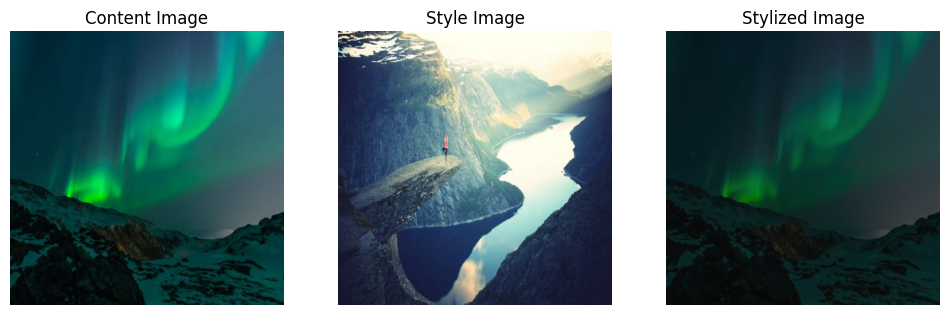

In [3]:
# Установка необходимых библиотек


import torch
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt

# Функция для загрузки изображения
def load_image(url, size=512):
    try:
        response = requests.get(url)
        response.raise_for_status()  # Проверка на успешный ответ
        img = Image.open(BytesIO(response.content)).convert('RGB')
        img = img.resize((size, size))
        return img
    except Exception as e:
        print(f"Ошибка загрузки изображения: {e}")
        return None  # Возвращаем None в случае ошибки

# Функция для отображения изображений
def imshow(tensor, title=None):
    image = tensor.clone().detach().cpu().numpy()
    image = image.squeeze(0)
    image = image.transpose(1, 2, 0)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Загрузка изображений
content_url = 'https://www.w3schools.com/w3images/lights.jpg'  # Контентное изображение
style_url = 'https://www.w3schools.com/w3images/fjords.jpg'    # Стильное изображение

# Загрузка изображений
content_image = load_image(content_url, size=512)  # Увеличение размера
style_image = load_image(style_url, size=512)

# Проверка, были ли загружены изображения
if content_image is None or style_image is None:
    print("Не удалось загрузить одно из изображений. Проверьте URL-адреса.")
else:
    # Преобразование изображений в тензоры
    preprocess = transforms.ToTensor()
    content_tensor = preprocess(content_image).unsqueeze(0)
    style_tensor = preprocess(style_image).unsqueeze(0)

    # Загрузка предобученной сети - используем менее "глубокую" сеть
    class SimpleNet(nn.Module):
        def __init__(self):
            super(SimpleNet, self).__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),  # Меньше фильтров
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=2, stride=2),
            )

        def forward(self, x):
            return self.features(x)

    # Инициализация сети
    simple_net = SimpleNet()

    # Пример стилизации (здесь просто пропускаем через сеть, без фактической стилизации)
    with torch.no_grad():
        stylized_image_tensor = simple_net(content_tensor)

    # Изменение размера stylized_image_tensor до размера content_tensor
    stylized_image_tensor = torch.nn.functional.interpolate(stylized_image_tensor, size=content_tensor.shape[2:], mode='bilinear', align_corners=False)

    # Изменение соотношения стиля и контента
    alpha = 0.5  # вес контента
    beta = 0.5   # вес стиля

    # Применяем только один из выходов сети, чтобы получить изображение с тем же числом каналов
    stylized_image_tensor = stylized_image_tensor.mean(dim=1, keepdim=True)  # Получаем среднее по каналам

    # Комбинирование изображения
    combined_image_tensor = alpha * content_tensor + beta * stylized_image_tensor

    # Отображение результатов
    plt.figure(figsize=(12, 12))
    plt.subplot(1, 3, 1)
    imshow(content_tensor, title='Content Image')
    plt.subplot(1, 3, 2)
    imshow(style_tensor, title='Style Image')
    plt.subplot(1, 3, 3)
    imshow(combined_image_tensor, title='Stylized Image')
    plt.show()

